# Tree Model Feature importance : 트리 모델의 변수 중요도

# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

# 데이터 로드

In [5]:
data = pd.read_csv('./data/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

# 필요한 함수 정의

In [6]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 데이터 준비하기

### 1) x, y로 나누기

In [8]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) train : validation 분할

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)
x_train.shape

(404, 12)

# Feature Importance

## 1) Decision Tree

##### 라이브러리 불러오기

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import *

##### 모델 생성

In [12]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

##### 모델 시각화

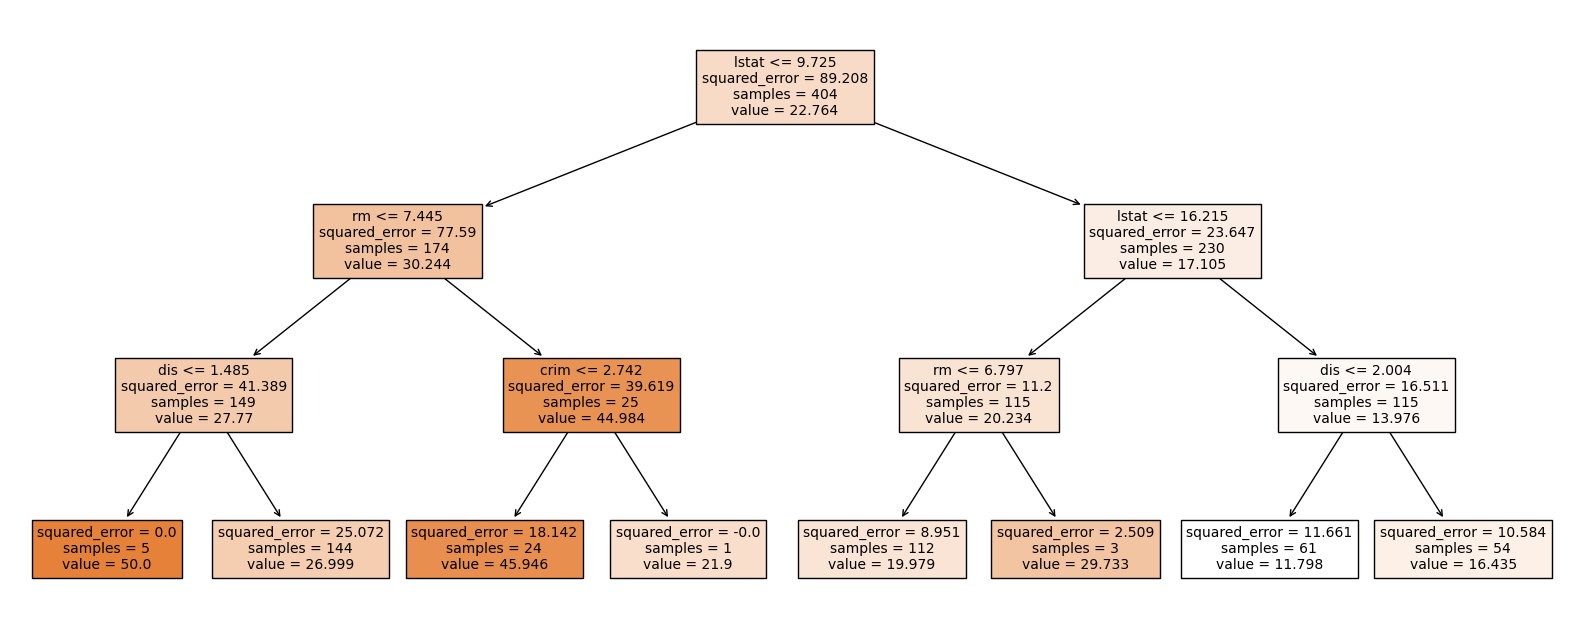

In [13]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10)
plt.show()

##### 변수 중요도

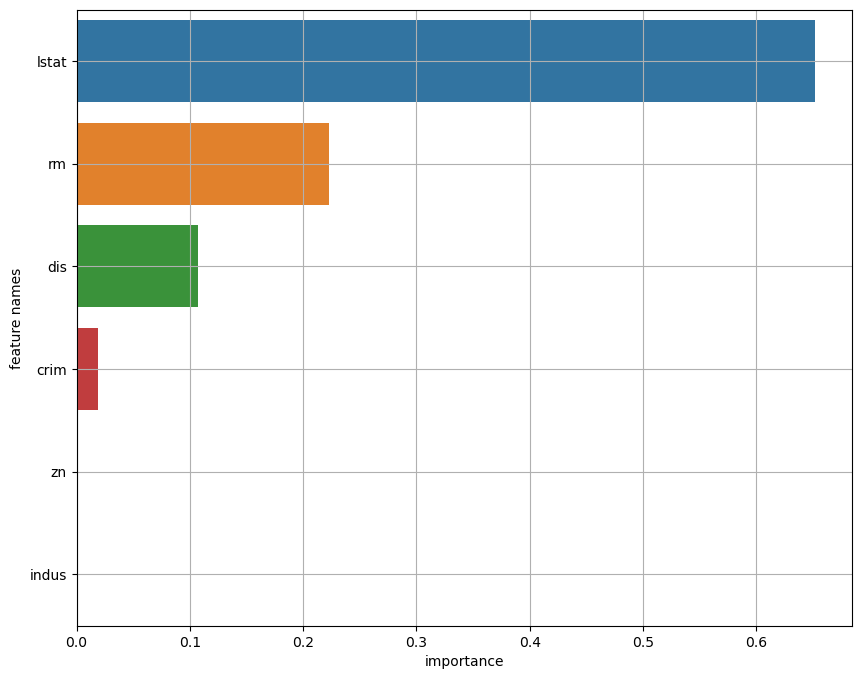

In [14]:
result = plot_feature_importance(model.feature_importances_, list(x), 6)

In [15]:
result

,feature_names,feature_importance
0,lstat,0.651574
1,rm,0.222928
2,dis,0.106809
3,crim,0.018688
4,zn,0.000000
5,indus,0.000000


##### 성능 최적화 이후 변수 중요도 다시 확인

In [16]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

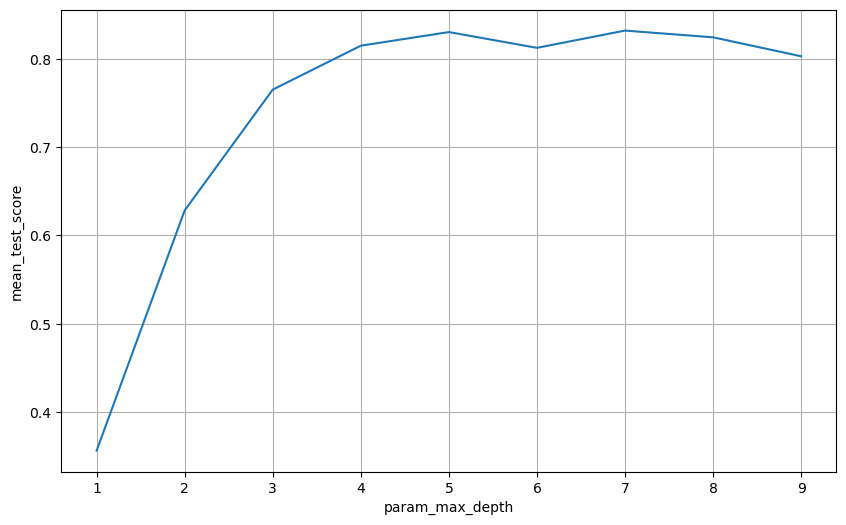

In [17]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [18]:
best_model = model_gs.best_estimator_

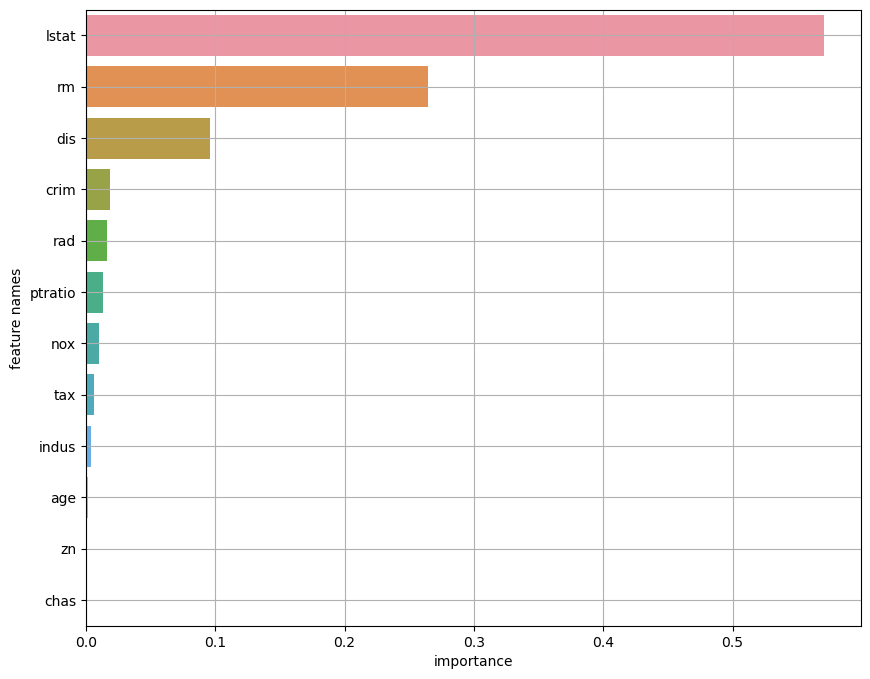

In [19]:
result = plot_feature_importance(best_model.feature_importances_, list(x),12)

In [20]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.9537569746094885


## 2) Random Forest

##### 라이브러리 불러오기

In [21]:
from sklearn.ensemble import RandomForestRegressor

##### 모델 생성

In [22]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

##### 모델 시각화

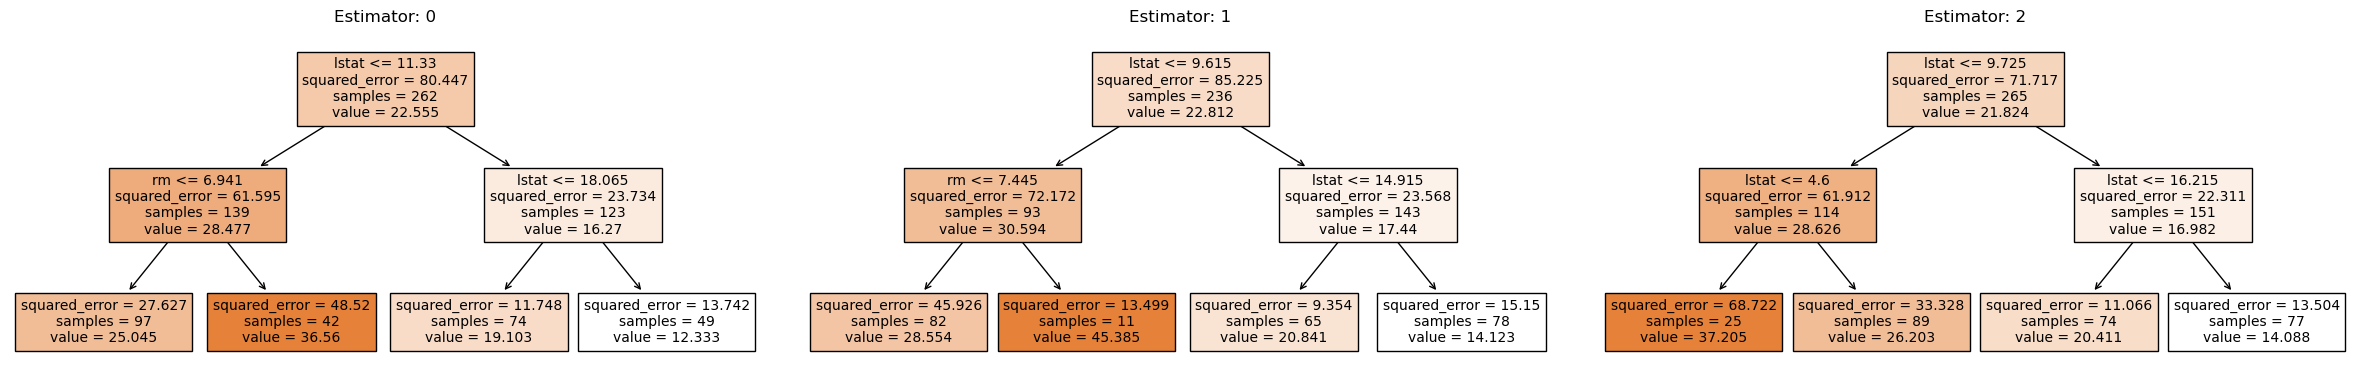

In [23]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)

plt.tight_layout()
plt.show()

In [25]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [26]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.250948,0.0,0.0,0.0,0.0,0.0,0.749052
1,0.0,0.0,0.0,0.0,0.0,0.202690,0.0,0.0,0.0,0.0,0.0,0.797310
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000


In [27]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.151212
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
lstat      0.848788
dtype: float64

In [28]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.151212,0.0,0.0,0.0,0.0,0.0,0.848788


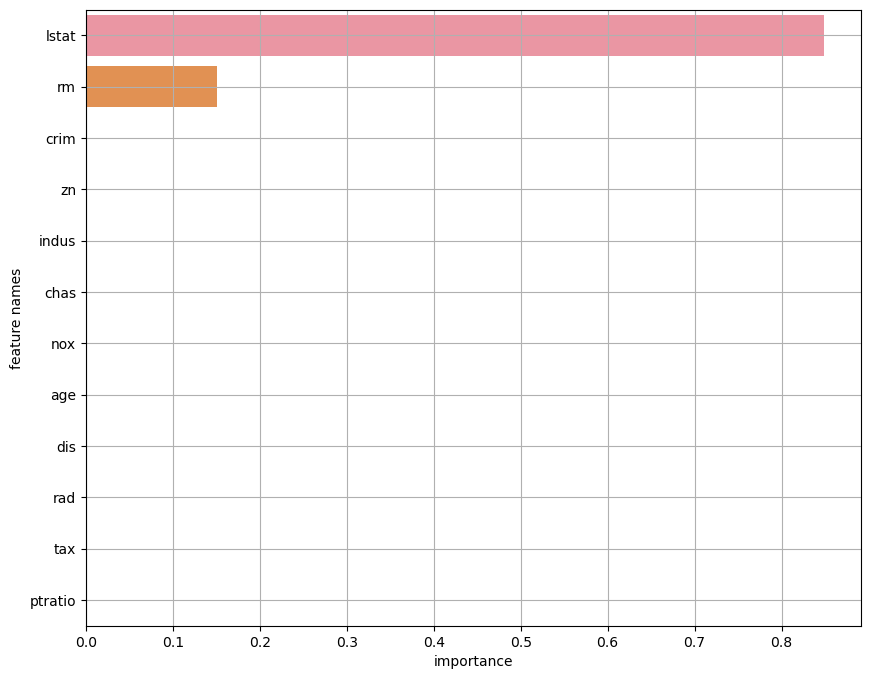

In [29]:
result = plot_feature_importance(model.feature_importances_, list(x))

##### tree = 100개 Random Forest 모델 만들기

In [31]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

##### 트리 전체 중요도 저장

In [32]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [33]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.051251,0.006656,0.000518,0.000286,0.009802,0.597761,0.009569,0.067466,0.001221,0.004729,0.028956,0.221784
1,0.101767,0.000113,0.003007,0.003117,0.023315,0.163001,0.013756,0.042841,0.005866,0.022472,0.025358,0.595387
2,0.014157,0.000305,0.005330,0.000383,0.022017,0.242716,0.004895,0.006422,0.047213,0.003567,0.010827,0.642169
3,0.096277,0.000782,0.002615,0.000921,0.011798,0.270513,0.007399,0.007265,0.003988,0.017004,0.005067,0.576371
4,0.035957,0.000742,0.002808,0.000572,0.021194,0.096538,0.054915,0.009624,0.001178,0.008385,0.010431,0.757656
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.010041,0.001376,0.004361,0.000156,0.013906,0.599008,0.005807,0.084214,0.006295,0.052849,0.007094,0.214893
96,0.089433,0.001153,0.001969,0.000004,0.003208,0.174166,0.011165,0.027252,0.007501,0.015690,0.007449,0.661009
97,0.059996,0.000034,0.005092,0.000088,0.025114,0.226108,0.009322,0.021879,0.001003,0.007626,0.014252,0.629487
98,0.044547,0.000265,0.022519,0.000916,0.014813,0.659877,0.016017,0.072092,0.000736,0.012704,0.013515,0.141999


##### 트리 100개의 평균 중요도

In [34]:
fi.mean(axis = 0)

crim       0.041685
zn         0.001323
indus      0.003786
chas       0.000654
nox        0.017646
rm         0.379819
age        0.016251
dis        0.062658
rad        0.005325
tax        0.011140
ptratio    0.015005
lstat      0.444708
dtype: float64

In [35]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.041685,0.001323,0.003786,0.000654,0.017646,0.379819,0.016251,0.062658,0.005325,0.01114,0.015005,0.444708


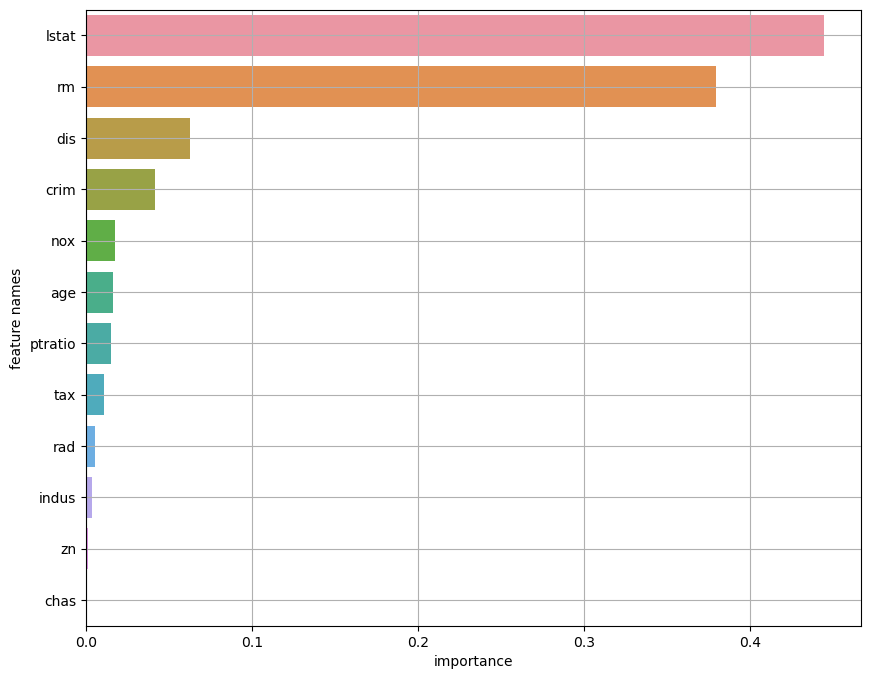

In [36]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [37]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.4677254901960772


## 3) XGB

##### 라이브러리 불러오기

In [38]:
from xgboost import XGBRegressor, plot_tree, plot_importance

##### 모델 생성

In [39]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

##### 모델 시각화

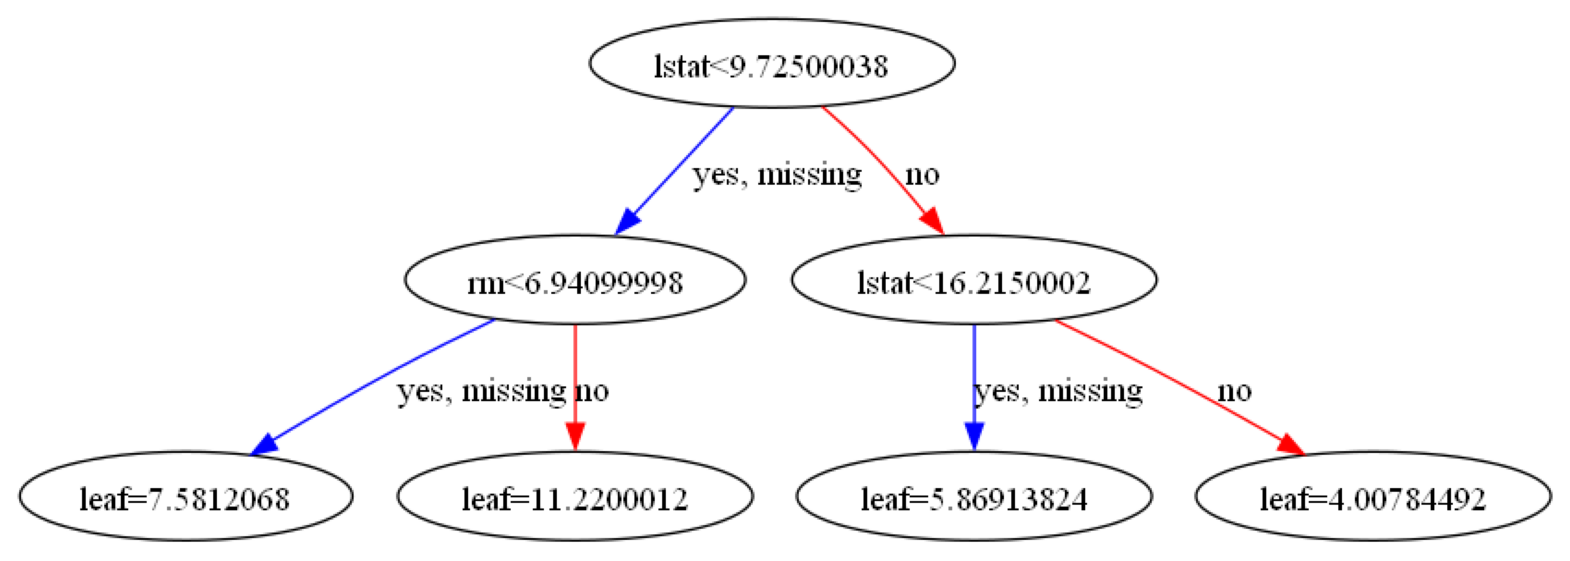

In [40]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.
* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

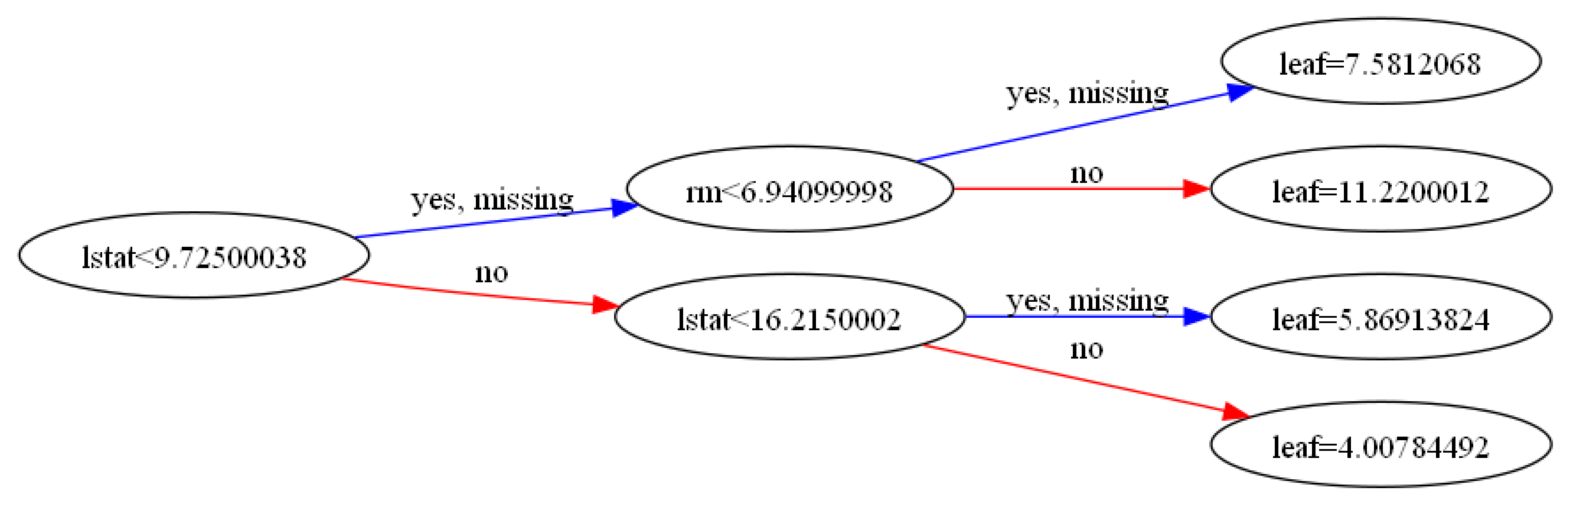

In [41]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

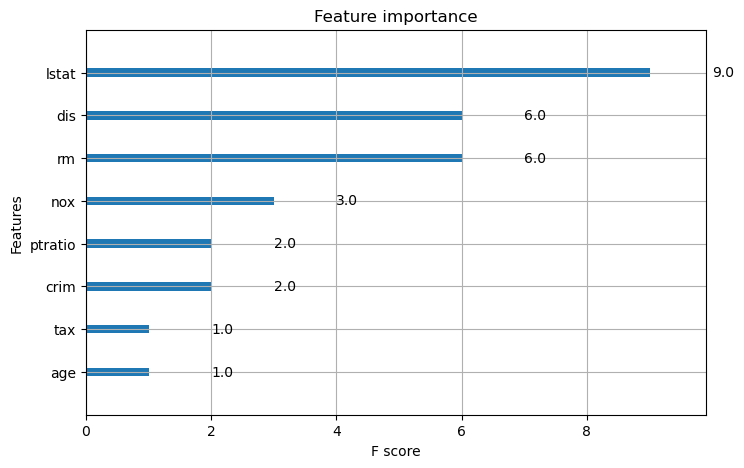

In [42]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

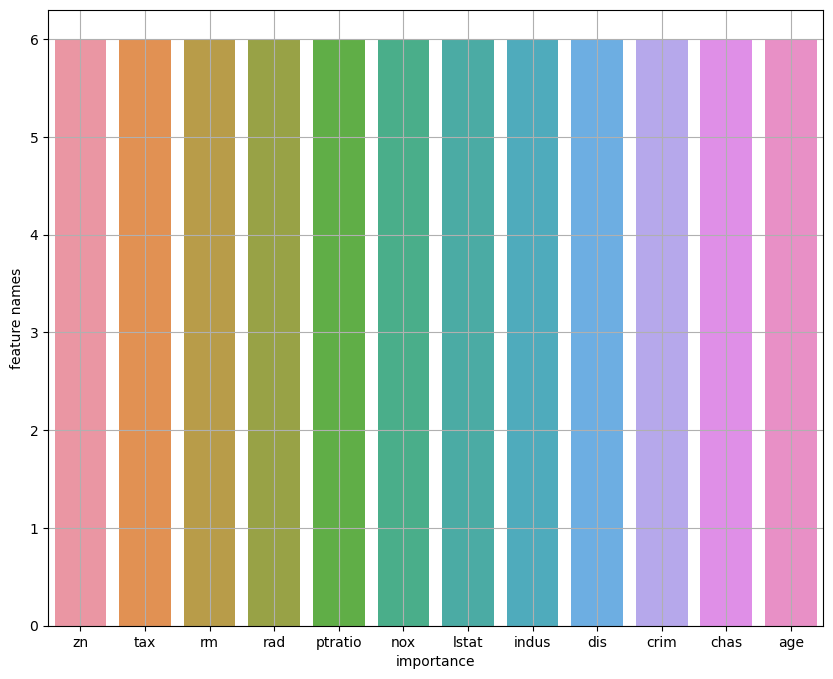

In [49]:
result = plot_feature_importance(list(x),6)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

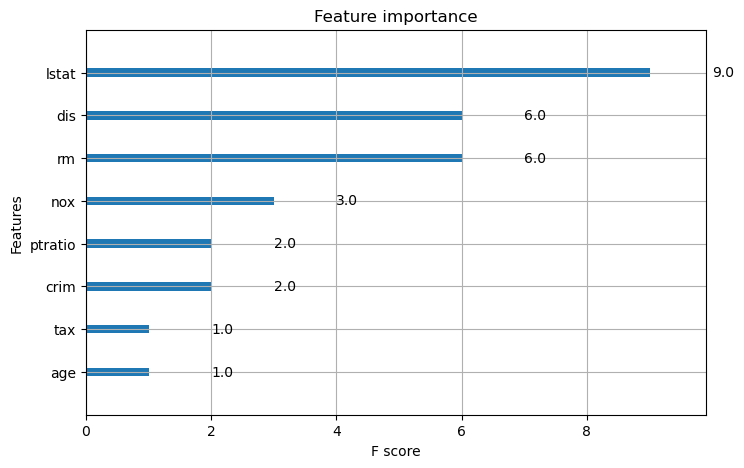

In [46]:
# importance_type='weight'
plot_importance(model)
plt.show()

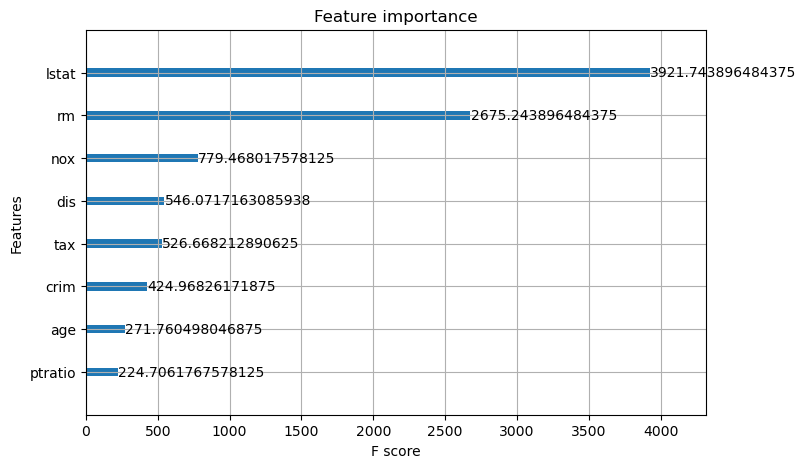

In [47]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

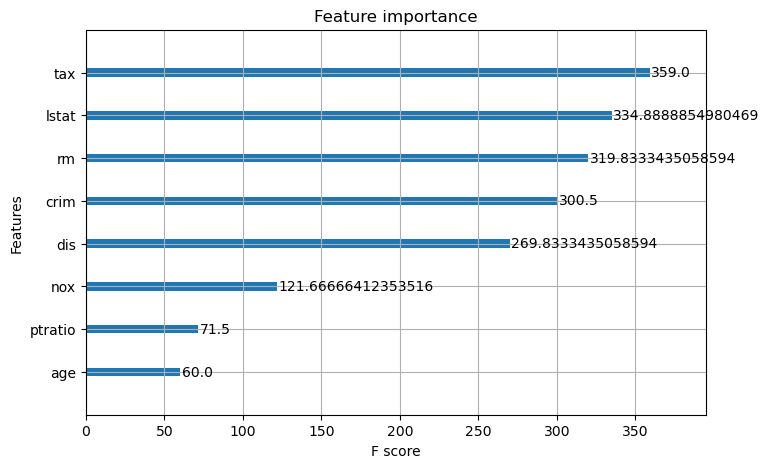

In [48]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()